# Assignment 2
The objective of this assignment is to get you familiarize with  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

You are using pip version 18.0, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Basic Imports
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import numpy as  np
import pandas as pd
from scipy import linalg as LA

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [4]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [5]:
# Loading the dataset
# IMFDB
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
# CFW
dirpath = './dataset/IIIT-CFW/'
X_cfw,y_cfw = load_data(dirpath)
N_cfw,H_cfw,W_cfw = X_cfw.shape[0:3]
C_cfw = 1 if opt['is_grayscale'] else X_cfw.shape[3]
# Yale
dirpath = './dataset/Yale_face_database/'
X_yale,y_yale = load_data(dirpath)
N_yale,H_yale,W_yale = X_yale.shape[0:3]
C_yale = 1 if opt['is_grayscale'] else X_yale.shape[3]

Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


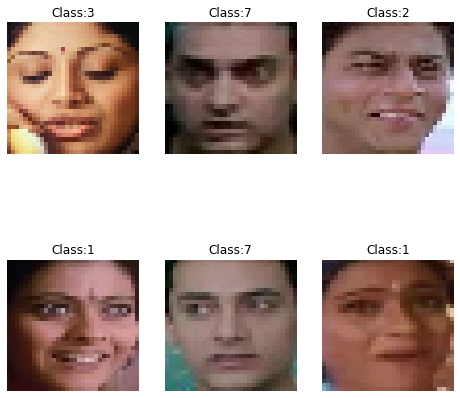

In [6]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [7]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [8]:
X_cfw = X_cfw.reshape((N_cfw,H_cfw*W_cfw*C_cfw))
X_yale = X_yale.reshape((N_yale,H_yale*W_yale*C_yale))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [9]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_r = pca.fit_transform(X)
    return X_r,pca

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [10]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree,fit_inverse_transform=True)
    X_r = kpca.fit_transform(X)
    return X_r,kpca

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [11]:
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, check_X_y

def inv_transform(lda, x):
    if lda.solver == 'lsqr':
        raise NotImplementedError("use 'svd' or 'eigen'")
    check_is_fitted(lda, ['xbar_', 'scalings_'], all_or_any=any)

    inv = np.linalg.pinv(lda.scalings_)

    x = check_array(x)
    if lda.solver == 'svd':
        x_back = np.dot(x, inv) + lda.xbar_
    elif lda.solver == 'eigen':
        x_back = np.dot(x, inv)

    return x_back

def get_lda(X,y,k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    if k < 7:
        raise NotImplementedError("k should be greater than or equal to 7")
    lda = LDA(n_components=k)
    X_r = lda.fit_transform(X,y)
    return X_r,lda

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [12]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
    
    if k < 7:
        raise NotImplementedError("k should be greater than or equal to 7")
    
    klda = LDA(n_components=k)
    X_r = klda.fit_transform(X_transformed,y)        
    return X_r , klda

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [13]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [14]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 
Eigen Faces is the set of eigen vectors extracted from the dataset of images of faces by performing dimensionality reduction algorithms. The images in the dataset can be reconstructed from this orthogonal basis set.

1(b).  How many eigen vectors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples and make a convincing argument.

Ans: we need 124, 309, 62 eigen vectors to reconstruct a person in datasets IMFDB, CFW, Yale respectively. These numericals are achieved by calculating the ratio of sum of eigen vectors taken and sum of all eigen vectors and equating it to 0.95

In [15]:
# Compute your features 
# eg.
X_3D,clf = get_kernel_lda(X,y,7)

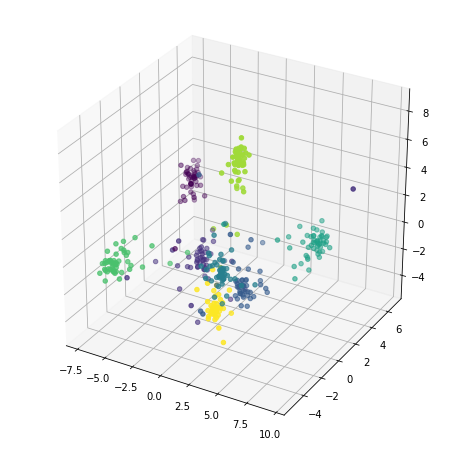

In [16]:
# Create a scatter plot  
# eg.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)

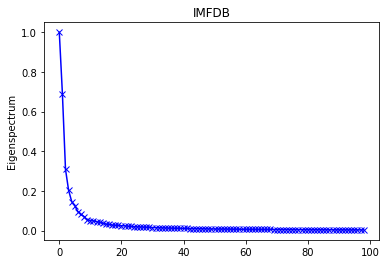

no.of eigenvectors required for IMFDB dataset: 124


In [17]:
# IMFDB
Cov = np.cov(np.transpose(X))
w, v = LA.eig(Cov)
e_val = (w - min(w)) / (max(w) - min(w))
plt.plot(e_val[0:99], color='blue', marker='x')
plt.ylabel('Eigenspectrum')
plt.title('IMFDB')
plt.show()

tot_sum = sum(w)
for i in range(len(w)):
    curr_sum = sum(w[:i])
    ratio = curr_sum / tot_sum
    if ratio >= 0.95:
        break
print("no.of eigenvectors required for IMFDB dataset:",i)

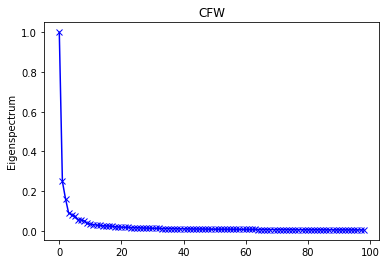

no.of eigenvectors required for CFW Dataset: 309


In [18]:
#CFW
Cov_cfw = np.cov(np.transpose(X_cfw))
w_cfw, v_cfw = LA.eig(Cov_cfw)
e_val_cfw = (w_cfw - min(w_cfw)) / (max(w_cfw) - min(w_cfw))
plt.plot(e_val_cfw[0:99], color='blue', marker='x')
plt.ylabel('Eigenspectrum')
plt.title('CFW')
plt.show()

tot_sum = sum(w_cfw)
for i in range(len(w_cfw)):
    curr_sum = sum(w_cfw[:i])
    ratio = curr_sum / tot_sum
    if ratio >= 0.95:
        break
print("no.of eigenvectors required for CFW Dataset:",i)

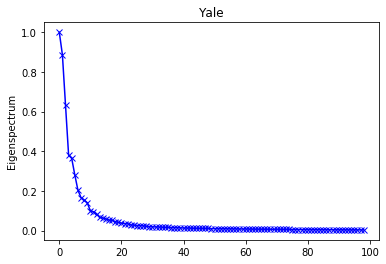

no.of eigenvectors required for Yale Dataset: 62


In [19]:
#Yale
Cov_yale = np.cov(np.transpose(X_yale))
w_yale, v_yale = LA.eig(Cov_yale)
e_val_yale = (w_yale - min(w_yale)) / (max(w_yale) - min(w_yale))
plt.plot(e_val_yale[0:99], color='blue', marker='x')
plt.ylabel('Eigenspectrum')
plt.title('Yale')
plt.show()

tot_sum = sum(w_yale)
for i in range(len(w_yale)):
    curr_sum = sum(w_yale[:i])
    ratio = curr_sum / tot_sum
    if ratio >= 0.95:
        break
print("no.of eigenvectors required for Yale Dataset:",i)

1(c). Reconstruct  the  image  back for each case


In [20]:
def reconstruct_images(X, y, k, feature):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    if feature == "pca":
        X_k,pca = get_pca(X,k)
        reconstruct_X = pca.inverse_transform(X_k)
        
    elif feature == "kernel_pca":
        X_k,kpca = get_kernel_pca(X,k)
        reconstruct_X = kpca.inverse_transform(X_k)
        
    elif feature == "lda":
        X_k,lda = get_lda(X, y, k)
        reconstruct_X = inv_transform(lda, X_k)
        
    elif feature == "kernel_lda":
        X_k, klda = get_kernel_lda(X, y, k)
        reconstruct_X = inv_transform(klda, X_k)    
        
    return reconstruct_X    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


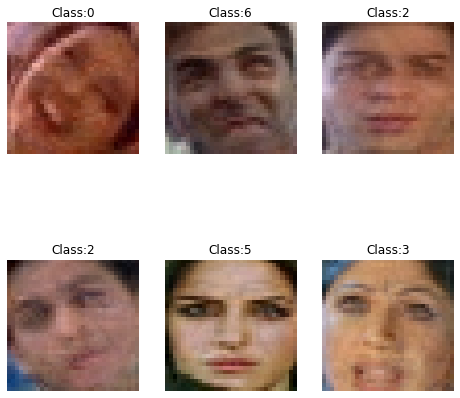

0.03328892744768508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


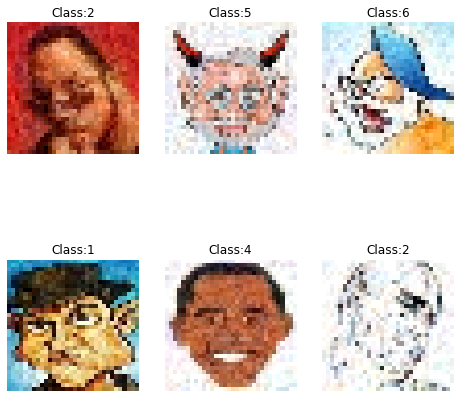

0.06571116078272993


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


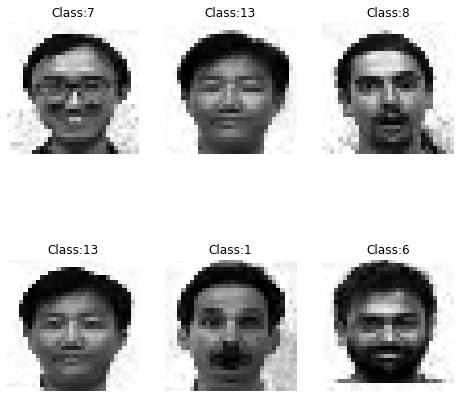

0.041205027046854394


In [21]:
#PCA

#IMFDB
# Display results 
X_reconstructed = reconstruct_images(X,y,150,"pca")
X_reconstructed_3D = X_reconstructed.reshape(N,H,W,C)
# Display random images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X_reconstructed_3D[ind,...],y[ind],row=2,col=3)
# Show the reconstruction error
print(np.sqrt(np.mean((X - X_reconstructed)**2)))

#CFW
# Display results 
X1_reconstructed = reconstruct_images(X_cfw,y_cfw,319,"pca")
X1_reconstructed_3D = X1_reconstructed.reshape(N_cfw,H_cfw,W_cfw,C_cfw)
# Display random images
ind = np.random.randint(0,y_cfw.shape[0],6)
disply_images(X1_reconstructed_3D[ind,...],y_cfw[ind],row=2,col=3)
# Show the reconstruction error
print(np.sqrt(np.mean((X_cfw - X1_reconstructed)**2)))

#Yale
# Display results 
X2_reconstructed = reconstruct_images(X_yale,y_yale,82,"pca")
X2_reconstructed_3D = X2_reconstructed.reshape(N_yale,H_yale,W_yale,C_yale)
# Display random images
ind = np.random.randint(0,y_yale.shape[0],6)
disply_images(X2_reconstructed_3D[ind,...],y_yale[ind],row=2,col=3)
# Show the reconstruction error
print(np.sqrt(np.mean((X_yale - X2_reconstructed)**2)))

1(d). Which person/identity is difficult to represent compactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

Ans: Amir khan(class 7) in IMFDB, Mamohan Singh(class 6) in CFW, person 7(class 7) in Yale dataset are difficult to represent. I see that because the error for these classes are high for many k's which means we are not able to represent them properly with the fewer eigen vectors.

In [22]:
err1 = 0
err2 = 0
err3 = 0
db1 = [0 for i in range(8)]
db2 = [0 for i in range(8)]
db3 = [0 for i in range(13)]
for k in range(11,20):
    F, pca1 = get_pca(X,k)
    F, pca2 = get_pca(X_cfw,k)
    for j in range(8):
        #IMFDB
        X1 = np.array([(X[i][:]) for i in range(X.shape[0]) if y[i] == j])
        y1 = np.array([(y[i]) for i in range(X.shape[0]) if y[i] == j])
        X1_k = pca1.transform(X1)
        X1_r = pca1.inverse_transform(X1_k)
        mse1 = (np.sqrt(np.mean((X1 - X1_r)**2)))
        if mse1 >= err1:
            err1 = mse1
            cls1 = j
        #CFW
        X2 = np.array([(X_cfw[i][:]) for i in range(X_cfw.shape[0]) if y_cfw[i] == j])
        y2 = np.array([(y_cfw[i]) for i in range(X_cfw.shape[0]) if y_cfw[i] == j])
        X2_k = pca2.transform(X2)
        X2_r = pca2.inverse_transform(X2_k)
        mse2 = (np.sqrt(np.mean((X2 - X2_r)**2)))
        if mse2 >= err2:
            err2 = mse2
            cls2 = j
        
    db1[cls1] += 1
    db2[cls2] += 1

for k in range(11,20):
    F, pca3 = get_pca(X_yale,k)
    for j in range(13):
        #Yale
        X3 = np.array([(X_yale[i][:]) for i in range(X_yale.shape[0]) if y_yale[i] == j])
        y3 = np.array([(y_yale[i]) for i in range(X_yale.shape[0]) if y_yale[i] == j])
        X3_k = pca3.transform(X3)
        X3_r = pca3.inverse_transform(X3_k)
        mse3 = (np.sqrt(np.mean((X3 - X3_r)**2)))
        if mse3 >= err3:
            err3 = mse3
            cls3 = j
    db3[cls3] += 1

print("IMFDB:",np.argmax(db1),"CFW:",np.argmax(db2),"Yale:",np.argmax(db3))

IMFDB: 7 CFW: 6 Yale: 7


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitive study. 

Ans: PCA+LDA+LR model is reasonably working well on all the datasets and has good accuracy. Resnet, VGG feature models works well when compared to other features as they take the features directly from the data. Yale dataset is really small to learn, Hence it works good with all the models.


You already know the paper [Face Recognition Using  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix as conf_mat
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self,clf_param):
        if clf_param == "logistic_regression":
            self.reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
        elif clf_param == "mlp":
            self.reg = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 50), random_state=1)
        elif clf_param == "svm":
            self.reg = SVC(gamma='auto')
        elif clf_param == "decision_trees":
            self.reg = DecisionTreeClassifier(random_state=0)

    def classify(self, X):
        prediction = self.reg.predict(X)        
        return prediction
        
    def confusion_matrix(self,pred,y):        
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        mat = conf_mat(y,pred)
        return mat 
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.reg.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """        
        y_pred = self.classify(X_validate)
        
        # Calculate Validation accuracy 
        accuracy = self.reg.score(X_validate,y_validate)*100
        
        # Create a confusion matrix
        cm  = self.confusion_matrix(y_pred, y_validate)
        
        # Calculate F1-score
        f1 = f1_score(y_validate, y_pred, average='micro')
        
        # Calculate precision and recall 
        precision = precision_score(y_validate, y_pred, average='micro')
        recall = recall_score(y_validate, y_pred, average='micro')
        
        #error
        error = 100 - accuracy

        return accuracy, cm, f1, precision, recall, error 

In [24]:
# Create a train and validation split to train your classifier 
from sklearn.model_selection import train_test_split

##IMFDB

#Pca + Lda + logisticReg
X_train,X_validate,y_train,y_validate = train_test_split(X,y,test_size=0.2)
X_pca,pca1 = get_pca(X_train,200)
X_lda,lda1 = get_lda(X_pca,y_train,200)

plm1_rds = X_lda.shape[1]
clf = Classifier("logistic_regression")
clf.train(X_lda,y_train)

X_test = pca1.transform(X_validate)
X_test = lda1.transform(X_test)
(plm1_acc, plm1_cm, plm1_f1, plm1_pre, plm1_rec, plm1_err) = clf.validate(X_test,y_validate)

# Kpca + mlp
X_train,X_validate,y_train,y_validate = train_test_split(X,y,test_size=0.2)
X_kpca,kpca1 = get_kernel_pca(X_train,124)

kmlp1_rds = X_kpca.shape[1]
clf = Classifier("mlp")
clf.train(X_kpca,y_train)

X_test = kpca1.transform(X_validate)
(kmlp1_acc, kmlp1_cm, kmlp1_f1, kmlp1_pre, kmlp1_rec, kmlp1_err) = clf.validate(X_test,y_validate)

#Resnet + Svm
X_train,X_validate,y_train,y_validate = train_test_split(X,y,test_size=0.2)
path = './dataset/IMFDB/'
X_resnet = get_resnet_features(path)
rsvm1_rds = X_resnet.shape[1]
X_t,X_v,y_t,y_v = train_test_split(X_resnet,y,test_size=0.2)

clf2 = Classifier("svm")
clf2.train(X_t,y_t)
(rsvm1_acc, rsvm1_cm, rsvm1_f1, rsvm1_pre, rsvm1_rec, rsvm1_err) = clf2.validate(X_v,y_v)
imfdb_cm = rsvm1_cm

#VGG + Svm
X_train,X_validate,y_train,y_validate = train_test_split(X,y,test_size=0.2)
path = './dataset/IMFDB/'
X_vgg = get_vgg_features(path)
vsvm1_rds = X_vgg.shape[1]
X_t,X_v,y_t,y_v = train_test_split(X_vgg,y,test_size=0.2)

clf = Classifier("svm")
clf.train(X_t,y_t)
(vsvm1_acc, vsvm1_cm, vsvm1_f1, vsvm1_pre, vsvm1_rec, vsvm1_err) = clf.validate(X_v,y_v)

#Lda + decisiontree
X_train,X_validate,y_train,y_validate = train_test_split(X,y,test_size=0.2)
X_klda,klda1 = get_lda(X_train,y_train,100)

dt1_rds = X_klda.shape[1]
clf = Classifier("decision_trees")
clf.train(X_klda,y_train)

X_test = klda1.transform(X_validate)
(dt1_acc, dt1_cm, dt1_f1, dt1_pre, dt1_rec, dt1_err) = clf.validate(X_test,y_validate)

#Vgg + mlp
X_train,X_validate,y_train,y_validate = train_test_split(X,y,test_size=0.2)
path = './dataset/IMFDB/'
X_vgg = get_vgg_features(path)
vmlp1_rds = X_vgg.shape[1]
X_t,X_v,y_t,y_v = train_test_split(X_vgg,y,test_size=0.2)

clf = Classifier("mlp")
clf.train(X_t,y_t)
(vmlp1_acc, vmlp1_cm, vmlp1_f1, vmlp1_pre, vmlp1_rec, vmlp1_err) = clf.validate(X_v,y_v)

In [25]:
# Create a train and validation split to train your classifier 

##CFW

#Pca + Lda + logisticReg
X_train,X_validate,y_train,y_validate = train_test_split(X_cfw,y_cfw,test_size=0.2)
X_trans,pca2 = get_pca(X_train,350)
X_lda,lda2 = get_lda(X_trans,y_train,130)

plm2_rds = X_lda.shape[1]
clf = Classifier("logistic_regression")
clf.train(X_lda,y_train)

X_test = pca2.transform(X_validate)
X_test = lda2.transform(X_test)
(plm2_acc, plm2_cm, plm2_f1, plm2_pre, plm2_rec, plm2_err) = clf.validate(X_test,y_validate)

# Kpca + mlp
X_train,X_validate,y_train,y_validate = train_test_split(X_cfw,y_cfw,test_size=0.2)
X_kpca,kpca2 = get_kernel_pca(X_train,305)

kmlp2_rds = X_kpca.shape[1]
clf1 = Classifier("mlp")
clf1.train(X_kpca,y_train)

X_test = kpca2.transform(X_validate)
(kmlp2_acc, kmlp2_cm, kmlp2_f1, kmlp2_pre, kmlp2_rec, kmlp2_err) = clf1.validate(X_test,y_validate)

#Resnet + Svm
X_train,X_validate,y_train,y_validate = train_test_split(X_cfw,y_cfw,test_size=0.2)
path = './dataset/IIIT-CFW/'
X_resnet = get_resnet_features(path)
rsvm2_rds = X_resnet.shape[1]
X_t,X_v,y_t,y_v = train_test_split(X_resnet,y_cfw,test_size=0.2)

clf = Classifier("svm")
clf.train(X_t,y_t)
(rsvm2_acc, rsvm2_cm, rsvm2_f1, rsvm2_pre, rsvm2_rec, rsvm2_err) = clf.validate(X_v,y_v)
cfw_cm = rsvm2_cm

#VGG + Svm
X_train,X_validate,y_train,y_validate = train_test_split(X_cfw,y_cfw,test_size=0.2)
path = './dataset/IIIT-CFW/'
X_vgg = get_vgg_features(path)
vsvm2_rds = X_vgg.shape[1]
X_t,X_v,y_t,y_v = train_test_split(X_vgg,y_cfw,test_size=0.2)

clf = Classifier("svm")
clf.train(X_t,y_t)
(vsvm2_acc, vsvm2_cm, vsvm2_f1, vsvm2_pre, vsvm2_rec, vsvm2_err) = clf.validate(X_v,y_v)

#Lda + decisiontree
X_train,X_validate,y_train,y_validate = train_test_split(X_cfw,y_cfw,test_size=0.2)
X_klda,klda2 = get_lda(X_train,y_train,100)

dt2_rds = X_klda.shape[1]
clf = Classifier("decision_trees")
clf.train(X_klda,y_train)

X_test = klda2.transform(X_validate)
(dt2_acc, dt2_cm, dt2_f1, dt2_pre, dt2_rec, dt2_err) = clf.validate(X_test,y_validate)

#Vgg + mlp
X_train,X_validate,y_train,y_validate = train_test_split(X_cfw,y_cfw,test_size=0.2)
path = './dataset/IIIT-CFW/'
X_vgg = get_vgg_features(path)
vmlp2_rds = X_vgg.shape[1]
X_t,X_v,y_t,y_v = train_test_split(X_vgg,y_cfw,test_size=0.2)

clf = Classifier("mlp")
clf.train(X_t,y_t)
(vmlp2_acc, vmlp2_cm, vmlp2_f1, vmlp2_pre, vmlp2_rec, vmlp2_err) = clf.validate(X_v,y_v)

In [26]:
# Create a train and validation split to train your classifier 

##Yale

#Pca + Lda + logisticReg
X_train,X_validate,y_train,y_validate = train_test_split(X_yale,y_yale,test_size=0.2)
X_trans,pca3 = get_pca(X_train,80)
X_lda,lda3 = get_lda(X_trans,y_train,200)

plm3_rds = X_lda.shape[1]
clf = Classifier("logistic_regression")
clf.train(X_lda,y_train)

X_test = pca3.transform(X_validate)
X_test = lda3.transform(X_test)
(plm3_acc, plm3_cm, plm3_f1, plm3_pre, plm3_rec, plm3_err) = clf.validate(X_test,y_validate)
yale_cm = plm3_cm

# Kpca + mlp
X_train,X_validate,y_train,y_validate = train_test_split(X_yale,y_yale,test_size=0.2)
X_kpca,kpca3 = get_kernel_pca(X_train,60)

kmlp3_rds = X_kpca.shape[1]
clf = Classifier("mlp")
clf.train(X_kpca,y_train)

X_test = kpca3.transform(X_validate)
(kmlp3_acc, kmlp3_cm, kmlp3_f1, kmlp3_pre, kmlp3_rec, kmlp3_err) = clf.validate(X_test,y_validate)

#Resnet + Svm
X_train,X_validate,y_train,y_validate = train_test_split(X_yale,y_yale,test_size=0.2)
path = './dataset/Yale_face_database/'
X_resnet = get_resnet_features(path)
rsvm3_rds = X_resnet.shape[1]
X_t,X_v,y_t,y_v = train_test_split(X_resnet,y_yale,test_size=0.2)

clf = Classifier("svm")
clf.train(X_t,y_t)
(rsvm3_acc, rsvm3_cm, rsvm3_f1, rsvm3_pre, rsvm3_rec, rsvm3_err) = clf.validate(X_v,y_v)

#VGG + Svm
X_train,X_validate,y_train,y_validate = train_test_split(X_yale,y_yale,test_size=0.2)
path = './dataset/Yale_face_database/'
X_vgg = get_vgg_features(path)
vsvm3_rds = X_vgg.shape[1]
X_t,X_v,y_t,y_v = train_test_split(X_vgg,y_yale,test_size=0.2)

clf = Classifier("svm")
clf.train(X_t,y_t)
(vsvm3_acc, vsvm3_cm, vsvm3_f1, vsvm3_pre, vsvm3_rec, vsvm3_err) = clf.validate(X_v,y_v)

#Lda + decisiontree
X_train,X_validate,y_train,y_validate = train_test_split(X_yale,y_yale,test_size=0.2)
X_klda,klda3 = get_lda(X_train,y_train,200)

dt3_rds = X_klda.shape[1]
clf = Classifier("decision_trees")
clf.train(X_klda,y_train)

X_test = klda3.transform(X_validate)
(dt3_acc, dt3_cm, dt3_f1, dt3_pre, dt3_rec, dt3_err) = clf.validate(X_test,y_validate)

#Vgg + mlp
X_train,X_validate,y_train,y_validate = train_test_split(X_yale,y_yale,test_size=0.2)
path = './dataset/Yale_face_database/'
X_vgg = get_vgg_features(path)
vmlp3_rds = X_vgg.shape[1]
X_t,X_v,y_t,y_v = train_test_split(X_vgg,y_yale,test_size=0.2)

clf = Classifier("mlp")
clf.train(X_t,y_t)
(vmlp3_acc, vmlp3_cm, vmlp3_f1, vmlp3_pre, vmlp3_rec, vmlp3_err) = clf.validate(X_v,y_v)

In [27]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score
# Print the table. (You can use Pandas)
print("............................IMFDB Table.....................................................")
df1 = pd.DataFrame({ 'feature' : pd.Categorical(["(PCA+LDA)+LR","KPCA+MLP","Resnet+SVM","VGG+SVM","LDA+DesicionTree","VGG+MLP"]),
                     'Reduced Dim' : ([plm1_rds,kmlp1_rds,rsvm1_rds,vsvm1_rds,dt1_rds,vmlp1_rds]),
                     'Clssn error' : ([plm1_err,kmlp1_err,rsvm1_err,vsvm1_err,dt1_err,vmlp1_err]),
                     'Accuracy' : ([plm1_acc,kmlp1_acc,rsvm1_acc,vsvm1_acc,dt1_acc,vmlp1_acc]),
                     'F1_score' : ([plm1_f1,kmlp1_f1,rsvm1_f1,vsvm1_f1,dt1_f1,vmlp1_f1]) })
print(df1)
print(".............................CFW Table......................................................")
df2 = pd.DataFrame({ 'feature' : pd.Categorical(["(PCA+LDA)+LR","KPCA+MLP","Resnet+SVM","VGG+SVM","LDA+DesicionTree","VGG+MLP"]),
                     'Reduced Dim' : ([plm2_rds,kmlp2_rds,rsvm2_rds,vsvm2_rds,dt2_rds,vmlp2_rds]),
                     'Clssn error' : ([plm2_err,kmlp2_err,rsvm2_err,vsvm2_err,dt2_err,vmlp2_err]),
                     'Accuracy' : ([plm2_acc,kmlp2_acc,rsvm2_acc,vsvm2_acc,dt2_acc,vmlp2_acc]),
                     'F1_score' : ([plm2_f1,kmlp2_f1,rsvm2_f1,vsvm2_f1,dt2_f1,vmlp2_f1]) })
print(df2)
print(".............................Yale Table.....................................................")
df3 = pd.DataFrame({ 'feature' : pd.Categorical(["(PCA+LDA)+LR","KPCA+MLP","Resnet+SVM","VGG+SVM","LDA+DesicionTree","VGG+MLP"]),
                     'Reduced Dim' : ([plm3_rds,kmlp3_rds,rsvm3_rds,vsvm3_rds,dt3_rds,vmlp3_rds]),
                     'Clssn error' : ([plm3_err,kmlp3_err,rsvm3_err,vsvm3_err,dt3_err,vmlp3_err]),
                     'Accuracy' : ([plm3_acc,kmlp3_acc,rsvm3_acc,vsvm3_acc,dt3_acc,vmlp3_acc]),
                     'F1_score' : ([plm3_f1,kmlp3_f1,rsvm3_f1,vsvm3_f1,dt3_f1,vmlp3_f1]) })
print(df3)

............................IMFDB Table.....................................................
            feature  Reduced Dim  Clssn error  Accuracy  F1_score
0      (PCA+LDA)+LR            7        16.25     83.75    0.8375
1          KPCA+MLP          124        31.25     68.75    0.6875
2        Resnet+SVM         2048         2.50     97.50    0.9750
3           VGG+SVM         4096         7.50     92.50    0.9250
4  LDA+DesicionTree            7        43.75     56.25    0.5625
5           VGG+MLP         4096        12.50     87.50    0.8750
.............................CFW Table......................................................
            feature  Reduced Dim  Clssn error   Accuracy  F1_score
0      (PCA+LDA)+LR            7    50.370370  49.629630  0.496296
1          KPCA+MLP          305    46.666667  53.333333  0.533333
2        Resnet+SVM         2048     0.740741  99.259259  0.992593
3           VGG+SVM         4096    30.370370  69.629630  0.696296
4  LDA+DesicionTr

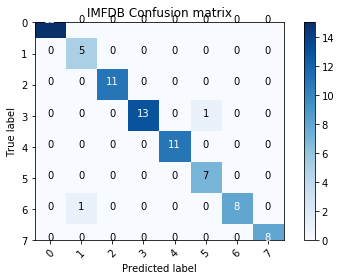

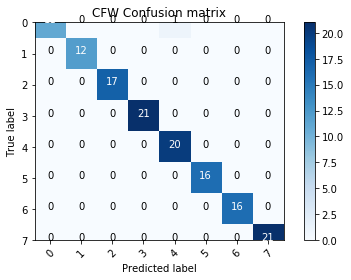

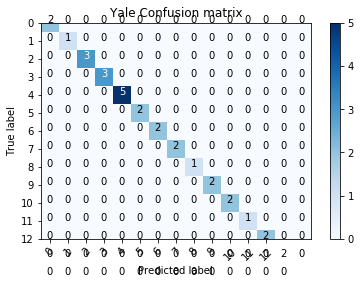

In [28]:
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(imfdb_cm, classes=['0', '1', '2', '3', '4', '5', '6', '7'], title='IMFDB Confusion matrix')
plot_confusion_matrix(cfw_cm, classes=['0', '1', '2', '3', '4', '5', '6', '7'], title='CFW Confusion matrix')
plot_confusion_matrix(yale_cm, classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], title='Yale Confusion matrix')

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together? or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for this course/exams.

Ans- TSNE is dimensionality reduction process, it reduces the redundant data. we can see same color dots forming clusters in the plots plotted below. Hence, can say that similar people come together.

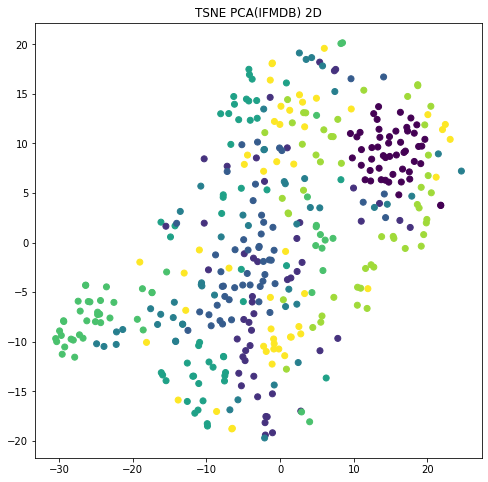

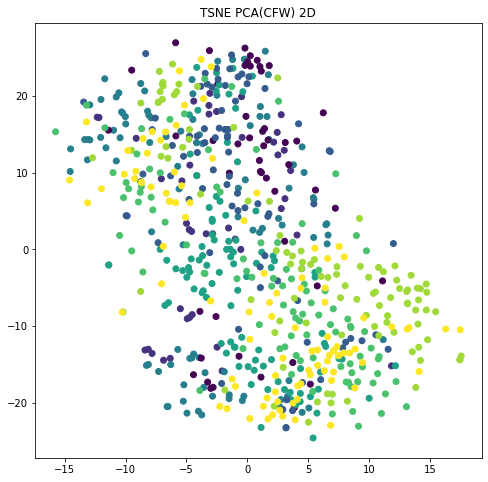

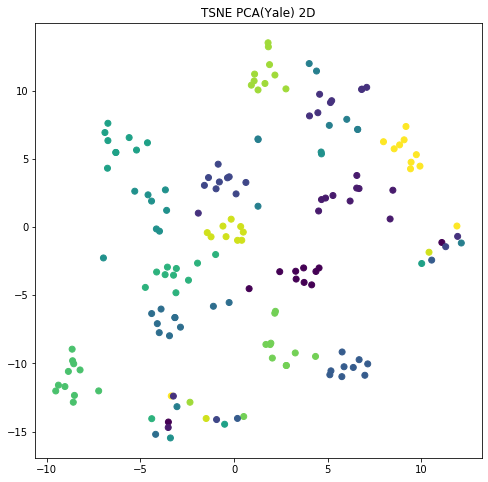

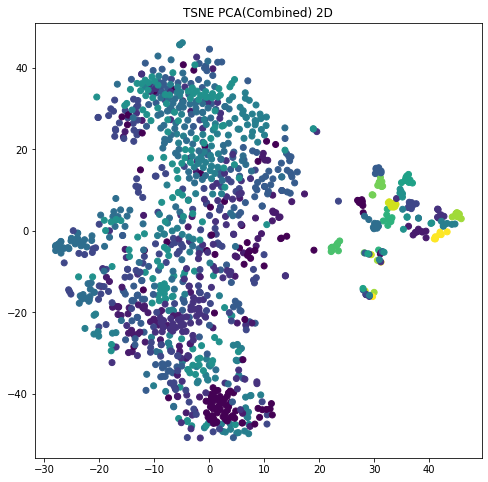

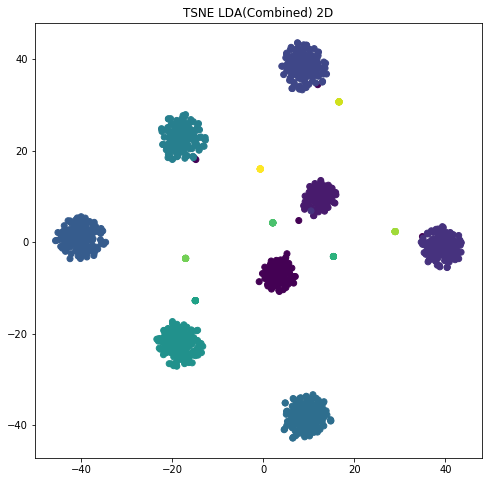

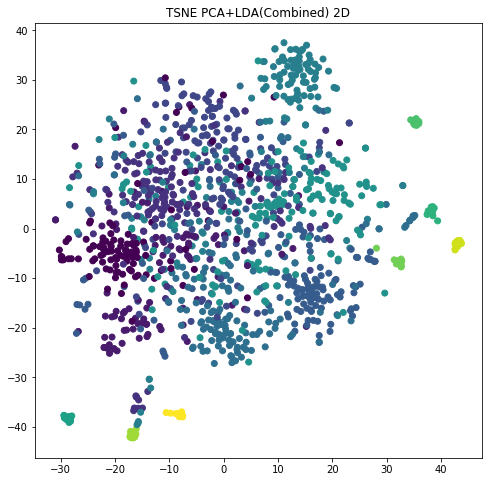

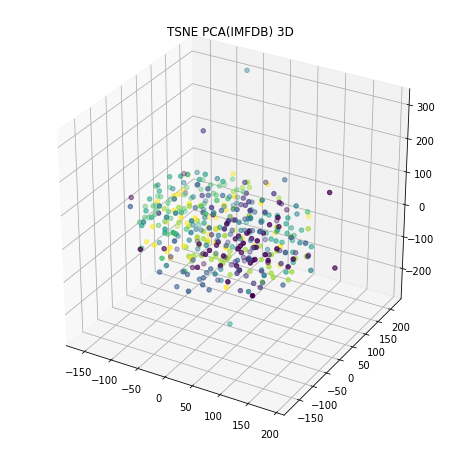

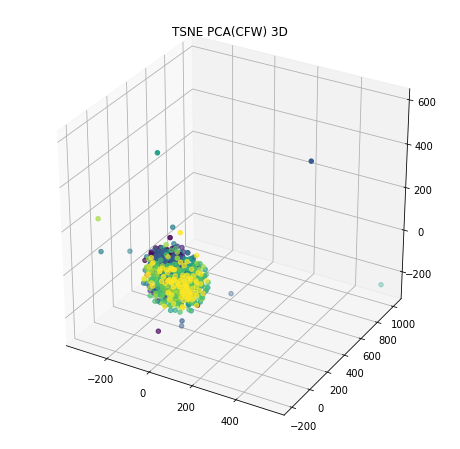

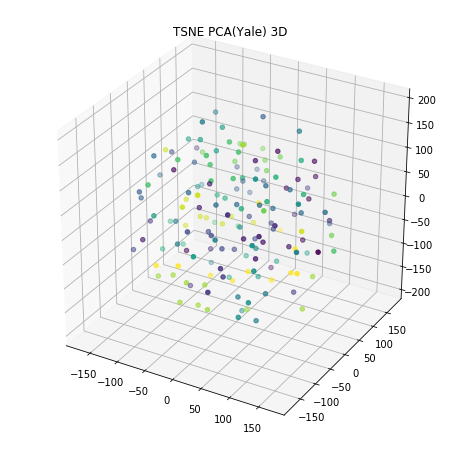

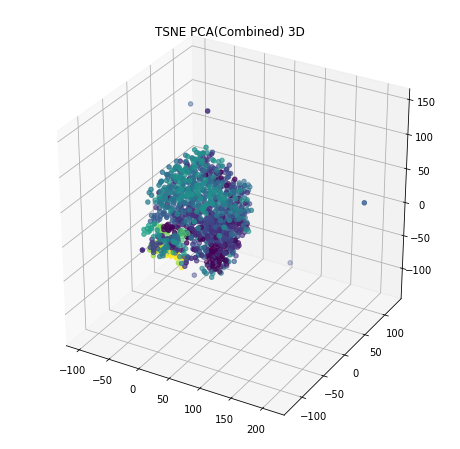

In [29]:
# Compute TSNE for different features and create a scatter plot
y_all = np.concatenate((y,y_cfw,y_yale))
X_combined = np.concatenate((X,X_cfw,X_yale))

#PCA
I,pca = get_pca(X,124)
C,pca1 = get_pca(X_cfw,124)
Y,pca2 = get_pca(X_yale,124)
X_pca,pca = get_pca(X_combined,124)

#LDA                            
X_lda,lda = get_lda(X_combined,y_all,124)

#PCA+LDA
X_pca,pca = get_pca(X_combined,124)
X_pla,lda = get_lda(X_pca,y_all,124)
                            
X21_TSNE = TSNE(n_components=2).fit_transform(I)
X22_TSNE = TSNE(n_components=2).fit_transform(C)
X23_TSNE = TSNE(n_components=2).fit_transform(Y)

# Plot the representation in 2d
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title("TSNE PCA(IFMDB) 2D")
ax.scatter(X21_TSNE[:,0],X21_TSNE[:,1],c=y)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title("TSNE PCA(CFW) 2D")
ax.scatter(X22_TSNE[:,0],X22_TSNE[:,1],c=y_cfw)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title("TSNE PCA(Yale) 2D")
ax.scatter(X23_TSNE[:,0],X23_TSNE[:,1],c=y_yale)

X2d1_TSNE = TSNE(n_components=2).fit_transform(X_pca)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title("TSNE PCA(Combined) 2D")
ax.scatter(X2d1_TSNE[:,0],X2d1_TSNE[:,1],c=y_all)

X2d2_TSNE = TSNE(n_components=2).fit_transform(X_lda)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title("TSNE LDA(Combined) 2D")
ax.scatter(X2d2_TSNE[:,0],X2d2_TSNE[:,1],c=y_all)

X2d3_TSNE = TSNE(n_components=2).fit_transform(X_pla)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title("TSNE PCA+LDA(Combined) 2D")
ax.scatter(X2d3_TSNE[:,0],X2d3_TSNE[:,1],c=y_all)

X31_TSNE = TSNE(n_components=3).fit_transform(I)
X32_TSNE = TSNE(n_components=3).fit_transform(C)
X33_TSNE = TSNE(n_components=3).fit_transform(Y)

# Plot the representation in 3d
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection='3d')
ax.set_title("TSNE PCA(IMFDB) 3D")
ax.scatter(X31_TSNE[:,0],X31_TSNE[:,1],X31_TSNE[:,2],c=y)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection='3d')
ax.set_title("TSNE PCA(CFW) 3D")
ax.scatter(X32_TSNE[:,0],X32_TSNE[:,1],X32_TSNE[:,2],c=y_cfw)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection='3d')
ax.set_title("TSNE PCA(Yale) 3D")
ax.scatter(X33_TSNE[:,0],X33_TSNE[:,1],X33_TSNE[:,2],c=y_yale)

X3d_TSNE = TSNE(n_components=3).fit_transform(X_pca)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection='3d')
ax.set_title("TSNE PCA(Combined) 3D")
ax.scatter(X3d_TSNE[:,0],X3d_TSNE[:,1],X3d_TSNE[:,2],c=y_all)

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

Ans: We train the model on training data and predict the labels for the test data based on the trained model along with the 'k' parameter (considering 'k' nearest neighbours for prediction) 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

Ans: We can analyze the performance of this model by comparing the predicted labels with the actual labels. The no.of correct preditions give the accuracy of the model.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [30]:
from sklearn.neighbors import KNeighborsClassifier

class FaceVerification():
    def __init__(self,k):
        self.clf = KNeighborsClassifier(n_neighbors=k)
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        pred_y = self.clf.predict(X)
        verification_results = [False for i in range(len(pred_y))]
        for i in range(len(pred_y)):
            if pred_y[i] == class_id[i]:
                verification_results[i] = True 
        return verification_results
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.clf.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        #Calc verification accuracy
        verify_vect = self.verify(X_validate,y_validate)
        verification_error = (len(verify_vect) - np.count_nonzero(verify_vect))*100/len(verify_vect)
        
        # Calculate accuracy 
        accuracy = self.clf.score(X_validate,y_validate)*100
        
        # Calculate precision
        y_pred = self.clf.predict(X_validate)
        precision = precision_score(y_validate, y_pred, average='micro')
        
        return accuracy, precision, verification_error

In [31]:
# Create a train and validation split and show your results 
##IMFDB

#Pca + Lda + knn9
X_train,X_validate,y_train,y_validate = train_test_split(X,y,test_size=0.2)
X_trans,pca1 = get_pca(X_train,200)
X_lda,lda1 = get_lda(X_trans,y_train,200)

plm1_rds = X_lda.shape[1]
clf = FaceVerification(9)
clf.train(X_lda,y_train)

X_test = pca1.transform(X_validate)
X_test = lda1.transform(X_test)
(plm1_acc, plm1_pre, plm1_err) = clf.validate(X_test,y_validate)

# Kpca + knn7
X_train,X_validate,y_train,y_validate = train_test_split(X,y,test_size=0.2)
X_kpca,kpca1 = get_kernel_pca(X_train,124)

kmlp1_rds = X_kpca.shape[1]
clf = FaceVerification(7)
clf.train(X_kpca,y_train)

X_test = kpca1.transform(X_validate)
(kmlp1_acc, kmlp1_pre, kmlp1_err) = clf.validate(X_test,y_validate)

#Resnet + knn7
X_train,X_validate,y_train,y_validate = train_test_split(X,y,test_size=0.2)
path = './dataset/IMFDB/'
X_resnet = get_resnet_features(path)
rsvm1_rds = X_resnet.shape[1]
X_t,X_v,y_t,y_v = train_test_split(X_resnet,y,test_size=0.2)

clf2 = FaceVerification(7)
clf2.train(X_t,y_t)
(rsvm1_acc, rsvm1_pre, rsvm1_err) = clf2.validate(X_v,y_v)
imfdb_cm = rsvm1_cm

#VGG + knn3
X_train,X_validate,y_train,y_validate = train_test_split(X,y,test_size=0.2)
path = './dataset/IMFDB/'
X_vgg = get_vgg_features(path)
vsvm1_rds = X_vgg.shape[1]
X_t,X_v,y_t,y_v = train_test_split(X_vgg,y,test_size=0.2)

clf = FaceVerification(3)
clf.train(X_t,y_t)
(vsvm1_acc, vsvm1_pre, vsvm1_err) = clf.validate(X_v,y_v)

#Lda + knn7
X_train,X_validate,y_train,y_validate = train_test_split(X,y,test_size=0.2)
X_klda,klda1 = get_lda(X_train,y_train,100)

dt1_rds = X_klda.shape[1]
clf = FaceVerification(7)
clf.train(X_klda,y_train)

X_test = klda1.transform(X_validate)
(dt1_acc, dt1_pre, dt1_err) = clf.validate(X_test,y_validate)

In [32]:
##CFW

#Pca + Lda + knn9
X_train,X_validate,y_train,y_validate = train_test_split(X_cfw,y_cfw,test_size=0.2)
X_trans,pca2 = get_pca(X_train,350)
X_lda,lda2 = get_lda(X_trans,y_train,200)

plm2_rds = X_lda.shape[1]
clf = FaceVerification(9)
clf.train(X_lda,y_train)

X_test = pca2.transform(X_validate)
X_test = lda2.transform(X_test)
(plm2_acc, plm2_pre, plm2_err) = clf.validate(X_test,y_validate)

# Kpca + knn7
X_train,X_validate,y_train,y_validate = train_test_split(X_cfw,y_cfw,test_size=0.2)
X_kpca,kpca2 = get_kernel_pca(X_train,135)

kmlp2_rds = X_kpca.shape[1]
clf1 = FaceVerification(7)
clf1.train(X_kpca,y_train)

X_test = kpca2.transform(X_validate)
(kmlp2_acc, kmlp2_pre, kmlp2_err) = clf1.validate(X_test,y_validate)

#Resnet + knn7
X_train,X_validate,y_train,y_validate = train_test_split(X_cfw,y_cfw,test_size=0.2)
path = './dataset/IIIT-CFW/'
X_resnet = get_resnet_features(path)
rsvm2_rds = X_resnet.shape[1]
X_t,X_v,y_t,y_v = train_test_split(X_resnet,y_cfw,test_size=0.2)

clf = FaceVerification(7)
clf.train(X_t,y_t)
(rsvm2_acc, rsvm2_pre, rsvm2_err) = clf.validate(X_v,y_v)
cfw_cm = rsvm2_cm

#VGG + knn3
X_train,X_validate,y_train,y_validate = train_test_split(X_cfw,y_cfw,test_size=0.2)
path = './dataset/IIIT-CFW/'
X_vgg = get_vgg_features(path)
vsvm2_rds = X_vgg.shape[1]
X_t,X_v,y_t,y_v = train_test_split(X_vgg,y_cfw,test_size=0.2)

clf = FaceVerification(3)
clf.train(X_t,y_t)
(vsvm2_acc, vsvm2_pre, vsvm2_err) = clf.validate(X_v,y_v)

#Lda + knn7
X_train,X_validate,y_train,y_validate = train_test_split(X_cfw,y_cfw,test_size=0.2)
X_klda,klda2 = get_lda(X_train,y_train,200)

dt2_rds = X_klda.shape[1]
clf = FaceVerification(7)
clf.train(X_klda,y_train)

X_test = klda2.transform(X_validate)
(dt2_acc, dt2_pre, dt2_err) = clf.validate(X_test,y_validate)

In [33]:
##Yale

#Pca + Lda + knn9
X_train,X_validate,y_train,y_validate = train_test_split(X_yale,y_yale,test_size=0.2)
X_trans,pca3 = get_pca(X_train,80)
X_lda,lda3 = get_lda(X_trans,y_train,130)

plm3_rds = X_lda.shape[1]
clf = FaceVerification(9)
clf.train(X_lda,y_train)

X_test = pca3.transform(X_validate)
X_test = lda3.transform(X_test)
(plm3_acc, plm3_pre, plm3_err) = clf.validate(X_test,y_validate)

# Kpca + knn7
X_train,X_validate,y_train,y_validate = train_test_split(X_yale,y_yale,test_size=0.2)
X_kpca,kpca3 = get_kernel_pca(X_train,60)

kmlp3_rds = X_kpca.shape[1]
clf = FaceVerification(7)
clf.train(X_kpca,y_train)

X_test = kpca3.transform(X_validate)
(kmlp3_acc, kmlp3_pre, kmlp3_err) = clf.validate(X_test,y_validate)

#Resnet + knn7
X_train,X_validate,y_train,y_validate = train_test_split(X_yale,y_yale,test_size=0.2)
path = './dataset/Yale_face_database/'
X_resnet = get_resnet_features(path)
rsvm3_rds = X_resnet.shape[1]
X_t,X_v,y_t,y_v = train_test_split(X_resnet,y_yale,test_size=0.2)

clf = FaceVerification(7)
clf.train(X_t,y_t)
(rsvm3_acc, rsvm3_pre, rsvm3_err) = clf.validate(X_v,y_v)
yale_cm = rsvm3_cm

#VGG + knn3
X_train,X_validate,y_train,y_validate = train_test_split(X_yale,y_yale,test_size=0.2)
path = './dataset/Yale_face_database/'
X_vgg = get_vgg_features(path)
vsvm3_rds = X_vgg.shape[1]
X_t,X_v,y_t,y_v = train_test_split(X_vgg,y_yale,test_size=0.2)

clf = FaceVerification(3)
clf.train(X_t,y_t)
(vsvm3_acc, vsvm3_pre, vsvm3_err) = clf.validate(X_v,y_v)

#Lda + knn7
X_train,X_validate,y_train,y_validate = train_test_split(X_yale,y_yale,test_size=0.2)
X_klda,klda3 = get_lda(X_train,y_train,130)

dt3_rds = X_klda.shape[1]
clf = FaceVerification(7)
clf.train(X_klda,y_train)

X_test = klda3.transform(X_validate)
(dt3_acc, dt3_pre, dt3_err) = clf.validate(X_test,y_validate)

In [34]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)
print("...........................IMFDB Table.....................................................")
df1 = pd.DataFrame({ 'feature' : pd.Categorical(["(PCA+LDA)+KNN9","KPCA+KNN7","Resnet+KNN7","VGG+KNN3","LDA+KNN7"]),
                     'Reduced Dim' : ([plm1_rds,kmlp1_rds,rsvm1_rds,vsvm1_rds,dt1_rds]),
                     'Verifn error' : ([plm1_err,kmlp1_err,rsvm1_err,vsvm1_err,dt1_err]),
                     'Accuracy' : ([plm1_acc,kmlp1_acc,rsvm1_acc,vsvm1_acc,dt1_acc]),
                     'Precision' : ([plm1_f1,kmlp1_f1,rsvm1_f1,vsvm1_f1,dt1_f1]) })
print(df1)
print("...........................CFW Table......................................................")
df2 = pd.DataFrame({ 'feature' : pd.Categorical(["(PCA+LDA)+KNN9","KPCA+KNN7","Resnet+KNN7","VGG+KNN3","LDA+KNN7"]),
                     'Reduced Dim' : ([plm2_rds,kmlp2_rds,rsvm2_rds,vsvm2_rds,dt2_rds]),
                     'Verifn error' : ([plm2_err,kmlp2_err,rsvm2_err,vsvm2_err,dt2_err]),
                     'Accuracy' : ([plm2_acc,kmlp2_acc,rsvm2_acc,vsvm2_acc,dt2_acc]),
                     'Precision' : ([plm2_f1,kmlp2_f1,rsvm2_f1,vsvm2_f1,dt2_f1]) })
print(df2)
print("..........................Yale Table.....................................................")
df3 = pd.DataFrame({ 'feature' : pd.Categorical(["(PCA+LDA)+KNN9","KPCA+KNN7","Resnet+KNN7","VGG+KNN3","LDA+KNN7"]),
                     'Reduced Dim' : ([plm3_rds,kmlp3_rds,rsvm3_rds,vsvm3_rds,dt3_rds]),
                     'Verifn error' : ([plm3_err,kmlp3_err,rsvm3_err,vsvm3_err,dt3_err]),
                     'Accuracy' : ([plm3_acc,kmlp3_acc,rsvm3_acc,vsvm3_acc,dt3_acc]),
                     'Precision' : ([plm3_f1,kmlp3_f1,rsvm3_f1,vsvm3_f1,dt3_f1]) })
print(df3)

...........................IMFDB Table.....................................................
          feature  Reduced Dim  Verifn error  Accuracy  Precision
0  (PCA+LDA)+KNN9            7         18.75     81.25     0.8375
1       KPCA+KNN7          124         58.75     41.25     0.6875
2     Resnet+KNN7         2048          5.00     95.00     0.9750
3        VGG+KNN3         4096         11.25     88.75     0.9250
4        LDA+KNN7            7         17.50     82.50     0.5625
...........................CFW Table......................................................
          feature  Reduced Dim  Verifn error   Accuracy  Precision
0  (PCA+LDA)+KNN9            7     49.629630  50.370370   0.496296
1       KPCA+KNN7          135     62.962963  37.037037   0.533333
2     Resnet+KNN7         2048      2.222222  97.777778   0.992593
3        VGG+KNN3         4096     32.592593  67.407407   0.696296
4        LDA+KNN7            7     65.185185  34.814815   0.281481
...................

### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [35]:
# Load data
My_X = np.concatenate((X,X_cfw))
My_y = [0 for i in range(My_X.shape[0])]

for i in range(y.shape[0]):
    if y[i] == 0 or y[i] == 1 or y[i] == 3 or y[i] == 5:
        My_y[i] = 1
for j in range(y_cfw.shape[0]):
    if y_cfw[j] == 3:
        My_y[j + X.shape[0]] = 1
My_y = np.array(My_y)
print(My_X.shape,My_y.shape)

(1072, 3072) (1072,)


In [36]:
Mx_train, Mx_test, y_train, y_test =  train_test_split(My_X,My_y,test_size=0.2)
#Pca + Clf
x1_train , pca = get_pca(Mx_train,200)
x1_test = pca.transform(Mx_test)
#Lda + Clf
x2_train, lda = get_lda(Mx_train,y_train,20)
x2_test = lda.transform(Mx_test)
#Pca + Lda + Clf
x1,pca1 = get_pca(Mx_train,200)
x3_train, lda1 = get_lda(x1,y_train,20)
x2 = pca1.transform(Mx_test)
x3_test = lda1.transform(x2)

In [37]:
# Create your classifier
# Validate your classifier
class My_Classifier():
    def __init__(self,clf_param):
        if clf_param == "logistic_regression":
            self.reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
        elif clf_param == "mlp":
            self.reg = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 50), random_state=1)
        elif clf_param == "svm":
            self.reg = SVC(gamma='auto')
        elif clf_param == "decision_trees":
            self.reg = DecisionTreeClassifier(random_state=0)

    def verify(self,X,class_id):
        pred_y = self.reg.predict(X)
        verification_results = [False for j in range(len(pred_y))]
        for i in range(len(pred_y)):
            if pred_y[i] == class_id[i]:
                verification_results[i] = True 
        return verification_results
        
    def train(self,X_train,y_train):
        self.reg.fit(X_train, y_train)
        return self.reg
    
    def validate(self,X_validate,y_validate):
        
        # Calculate Validation accuracy 
        accuracy = self.reg.score(X_validate,y_validate)*100
        
        return accuracy 

#Pca + Clf
clf = My_Classifier("logistic_regression")
clf.train(x1_train,y_train)
accuracy11 = clf.validate(x1_test,y_test)
clf = My_Classifier("svm")
clf.train(x1_train,y_train)
accuracy12 = clf.validate(x1_test,y_test)
clf = My_Classifier("mlp")
clf.train(x1_train,y_train)
accuracy13 = clf.validate(x1_test,y_test)
clf = My_Classifier("decision_trees")
clf.train(x1_train,y_train)
accuracy14 = clf.validate(x1_test,y_test)
#Lda + Clf
clf = My_Classifier("logistic_regression")
clf.train(x2_train,y_train)
accuracy21 = clf.validate(x2_test,y_test)
clf = My_Classifier("svm")
clf.train(x2_train,y_train)
accuracy22 = clf.validate(x2_test,y_test)
clf = My_Classifier("mlp")
clf.train(x2_train,y_train)
accuracy23 = clf.validate(x2_test,y_test)
clf = My_Classifier("decision_trees")
clf.train(x2_train,y_train)
accuracy24 = clf.validate(x2_test,y_test)
#Pca + Lda + Clf
clf = My_Classifier("logistic_regression")
clf.train(x3_train,y_train)
accuracy31 = clf.validate(x3_test,y_test)
clf = My_Classifier("svm")
clf.train(x3_train,y_train)
accuracy32 = clf.validate(x3_test,y_test)
clf = My_Classifier("mlp")
clf.train(x3_train,y_train)
accuracy33 = clf.validate(x3_test,y_test)
clf = My_Classifier("decision_trees")
clf.train(x3_train,y_train)
accuracy34 = clf.validate(x3_test,y_test)

                   feature   Accuracy
0                   PCA+LR  82.325581
1                  PCA+SVM  86.511628
2                  PCA+MLP  86.511628
3         PCA+DecisionTree  72.558140
4                   LDA+LR  72.093023
5                  LDA+SVM  58.139535
6                  LDA+MLP  73.488372
7         LDA+DecisionTree  74.418605
8             (PCA+LDA)+LR  79.534884
9            (PCA+LDA)+SVM  78.604651
10           (PCA+LDA)+MLP  79.534884
11  (PCA+LDA)+DecisionTree  76.744186
PCA+LR varaince for k-fold validation: 6.98430182591827
LDA+LR varaince for k-fold validation: 0.8779946278126598
PCA+LDA+LR varaince for k-fold validation: 6.5984768917946015


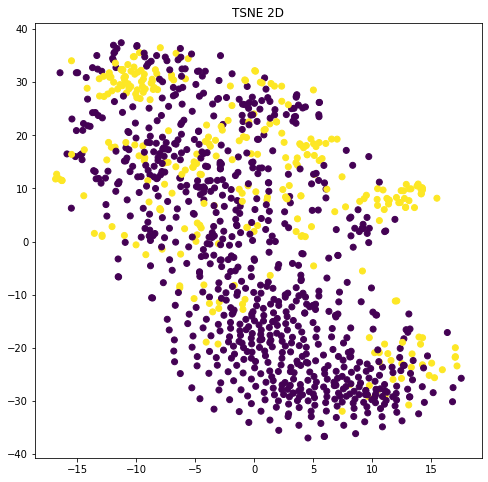

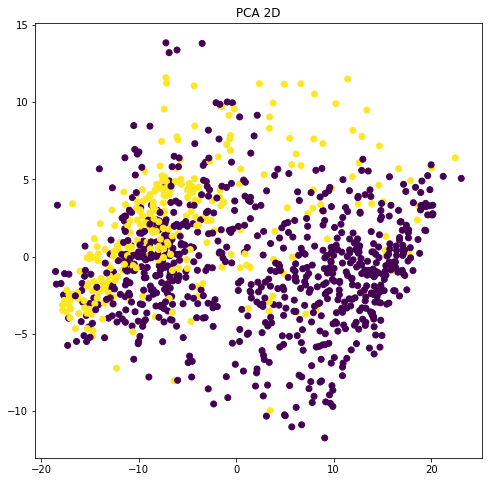

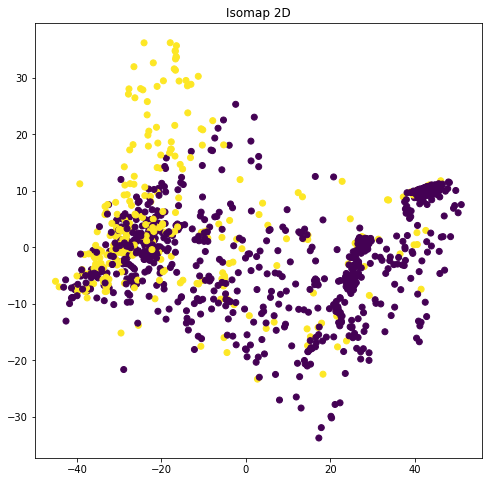

In [38]:
from sklearn.model_selection import KFold
from sklearn.manifold import Isomap

# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  
df3 = pd.DataFrame({ 'feature' : pd.Categorical(["PCA+LR","PCA+SVM","PCA+MLP","PCA+DecisionTree","LDA+LR","LDA+SVM","LDA+MLP","LDA+DecisionTree","(PCA+LDA)+LR","(PCA+LDA)+SVM","(PCA+LDA)+MLP","(PCA+LDA)+DecisionTree"]),
                     'Accuracy' : ([accuracy11,accuracy12,accuracy13,accuracy14,accuracy21,accuracy22,accuracy23,accuracy24,accuracy31,accuracy32,accuracy33,accuracy34])})
print(df3)

kf = KFold(n_splits=10,shuffle=True)
acc1 = []
X11,pca1 = get_pca(My_X,200)
for train_index, test_index in kf.split(X11):
    X1, X2, y1, y2 = X11[train_index], X11[test_index], My_y[train_index], My_y[test_index]
    clf = My_Classifier("logistic_regression")
    clf.train(X1,y1)
    acc1.append(clf.validate(X2,y2))
acc1 = np.array(acc1)
var1 = np.var(acc1)
print("PCA+LR varaince for k-fold validation:",var1)
acc2 = []
X12,pca1 = get_lda(My_X,My_y,200)
for train_index, test_index in kf.split(X12):
    X1, X2, y1, y2 = X12[train_index], X12[test_index], My_y[train_index], My_y[test_index]
    clf = My_Classifier("logistic_regression")
    clf.train(X1,y1)
    acc2.append(clf.validate(X2,y2))
acc2 = np.array(acc2)
var2 = np.var(acc2)
print("LDA+LR varaince for k-fold validation:",var2)
acc3 = []
X12,pca2 = get_pca(My_X,200)
X22,lda2 = get_lda(X12,My_y,200) 
for train_index, test_index in kf.split(X22):
    X1, X2, y1, y2 = X22[train_index], X22[test_index], My_y[train_index], My_y[test_index]
    clf = My_Classifier("logistic_regression")
    clf.train(X1,y1)
    acc3.append(clf.validate(X2,y2))
acc3 = np.array(acc3)
var3 = np.var(acc3)
print("PCA+LDA+LR varaince for k-fold validation:",var3)

##TSNE
X1_TSNE = TSNE(n_components=2).fit_transform(My_X)
# Plot the representation in 2d
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title("TSNE 2D")
ax.scatter(X1_TSNE[:,0],X1_TSNE[:,1],c=My_y)

##PCA
X1_red,clf = get_pca(My_X,2)
# Plot the representation in 2d
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title('PCA 2D')
ax.scatter(X1_red[:,0],X1_red[:,1],c=My_y)

##Isomap
em = Isomap(n_components=2)
X_trans = em.fit_transform(My_X)
# Plot the representation in 2d
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title('Isomap 2D')
ax.scatter(X_trans[:,0],X_trans[:,1],c=My_y)

correctly predicted images


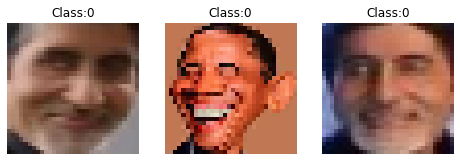

wrongly predicted images


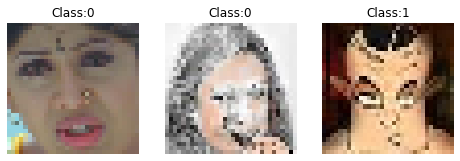

In [39]:
# Show quantitative results such as examples of correct prediction and wrong prediction
clf1 = My_Classifier("logistic_regression")
reg = clf1.train(Mx_train,y_train)
vect = clf1.verify(Mx_test,y_test)
Y_pred = reg.predict(Mx_test)

crct=[]
wrng=[]
for i in range(len(vect)):
    if len(crct) >=3 and len(wrng) >=3:
        break
    if vect[i]==True and len(crct) <3:
        crct.append(i)
    elif vect[i]==False and len(wrng) <3:
        wrng.append(i)

M_test = Mx_test.reshape(215,32,32,3)

# Display correctly predicted images
print("correctly predicted images")
disply_images(M_test[crct,...],Y_pred[crct],row=1,col=3)

# Display wrongly predicted images
print("wrongly predicted images")
disply_images(M_test[wrng,...],Y_pred[wrng],row=1,col=3)